In [1]:
# ← All libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


df = pd.read_excel('EastWestAirlines (2).xlsx', sheet_name='data')
df = df.drop('ID#', axis=1)
df.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [2]:
# ← No missing values in this file
print("Total missing values:", df.isnull().sum().sum())

Total missing values: 0


In [3]:
# ← Columns that are truly numeric
num_cols = ['Balance','Qual_miles','Bonus_miles','Bonus_trans',
            'Flight_miles_12mo','Flight_trans_12','Days_since_enroll']

z = np.abs(stats.zscore(df[num_cols]))
df_clean = df[(z < 3).all(axis=1)]

print("Original shape :", df.shape)
print("After outlier removal :", df_clean.shape)

Original shape : (3999, 11)
After outlier removal : (3677, 11)


In [4]:
scaler = StandardScaler()
data_std = scaler.fit_transform(df_clean)
print("Scaled data shape :", data_std.shape)

Scaled data shape : (3677, 11)


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000,3677.000000
mean,60434.353277,39.400054,1.989394,1.014142,1.005167,14410.789774,10.535219,256.386728,0.789230,4060.139788,0.339679
std,61664.122500,248.356124,1.318301,0.146843,0.115339,18233.239147,8.248762,637.018787,1.829636,2051.260604,0.473665
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,17500.000000,0.000000,1.000000,1.000000,1.000000,1058.000000,3.000000,0.000000,0.000000,2287.000000,0.000000
50%,39313.000000,0.000000,1.000000,1.000000,1.000000,6000.000000,11.000000,0.000000,0.000000,4010.000000,0.000000
75%,82122.000000,0.000000,3.000000,1.000000,1.000000,21634.000000,16.000000,150.000000,1.000000,5710.000000,1.000000
max,370941.000000,2454.000000,5.000000,3.000000,5.000000,89360.000000,39.000000,4652.000000,12.000000,8296.000000,1.000000


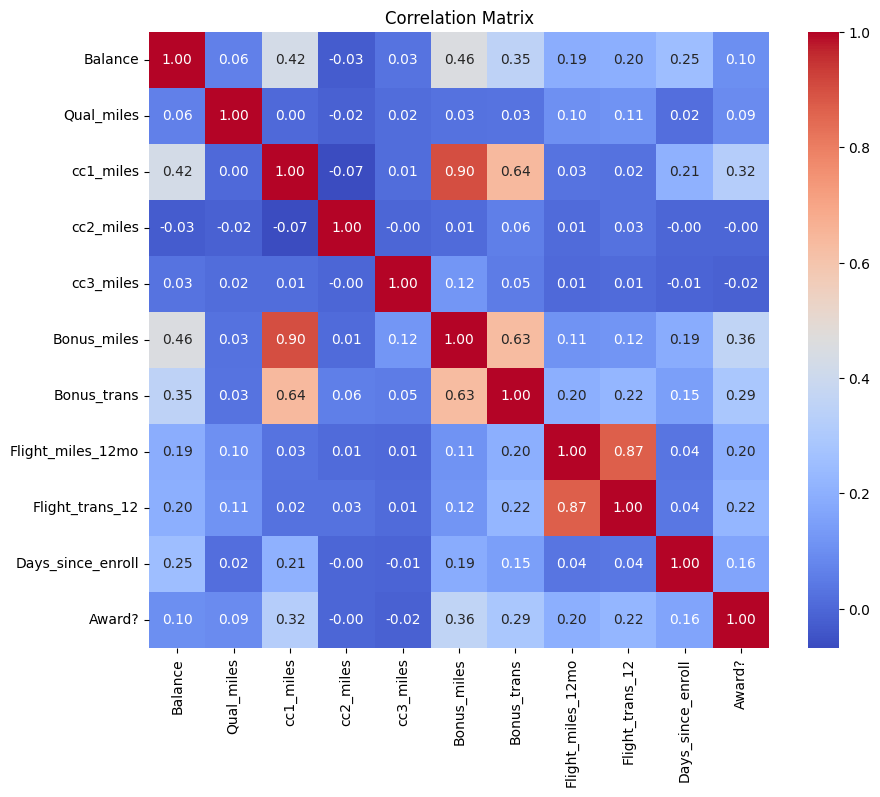

In [5]:
# Summary statistics
display(df_clean.describe())

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

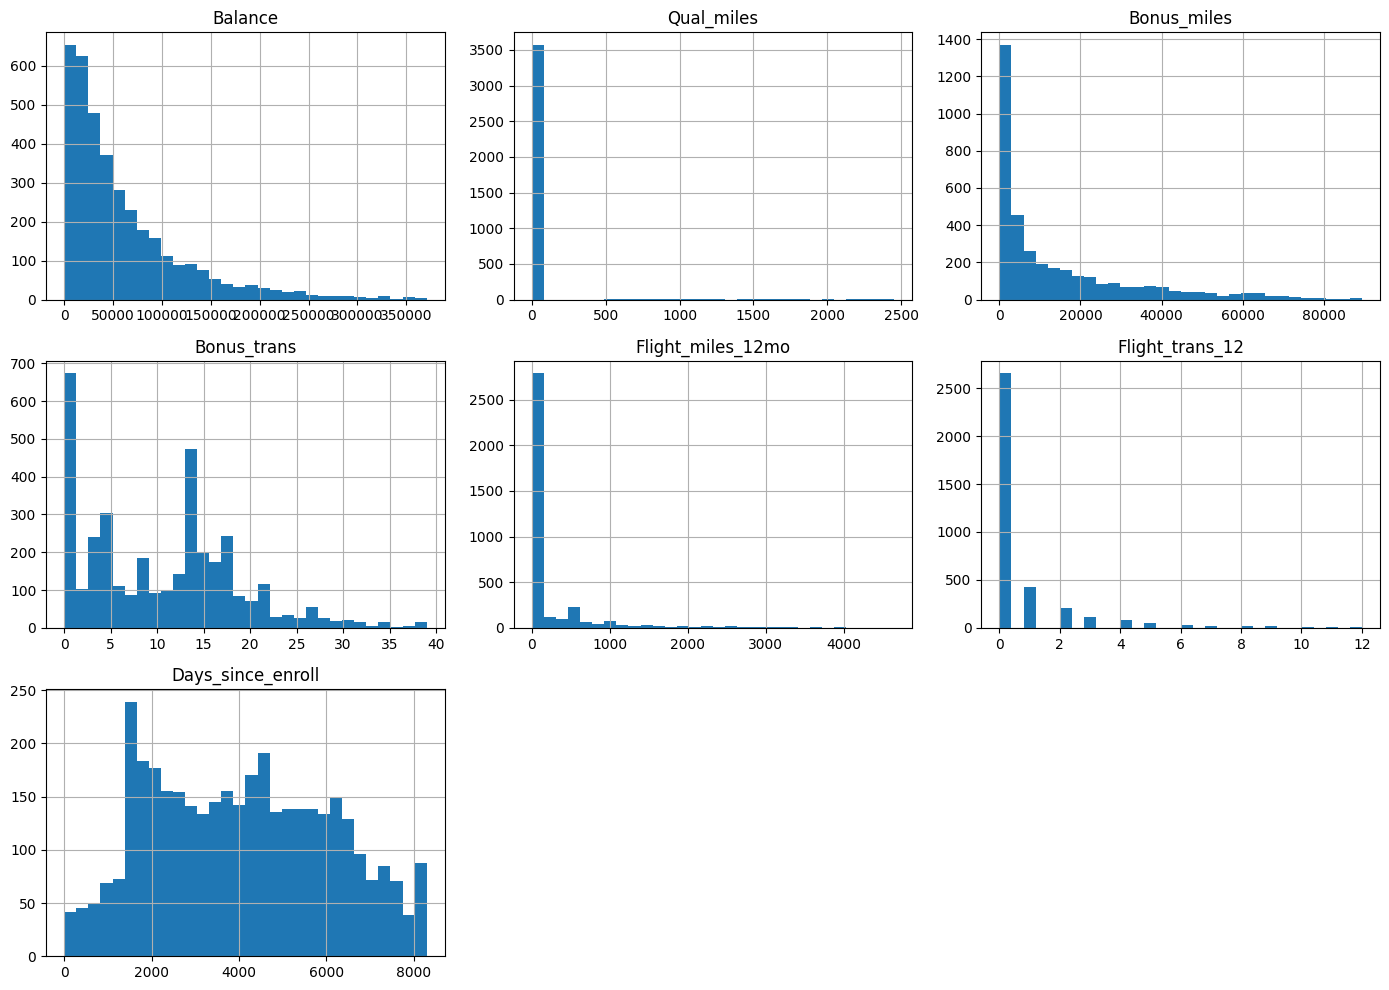

In [6]:
df_clean[num_cols].hist(bins=30, figsize=(14,10), layout=(3,3))
plt.tight_layout()
plt.show()

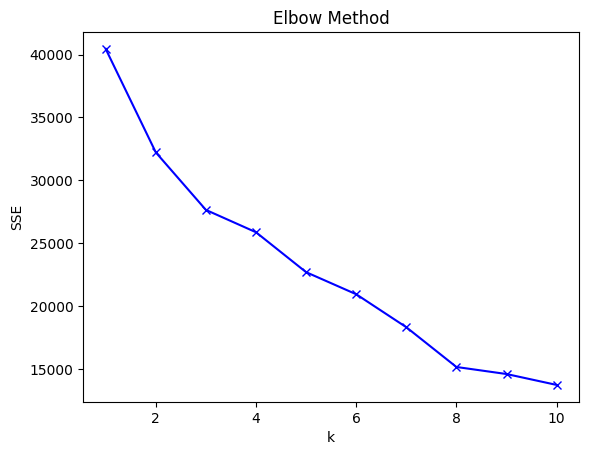

In [7]:
sse = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_std)
    sse.append(km.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_km = kmeans.fit_predict(data_std)

# Add labels to original clean dataframe
df_clean['Cluster_KM'] = labels_km
print("K-Means cluster sizes:")
print(pd.Series(labels_km).value_counts().sort_index())

K-Means cluster sizes:
0    1643
1     243
2    1111
3     680
Name: count, dtype: int64


/tmp/ipython-input-4107448814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster_KM'] = labels_km


In [9]:
db = DBSCAN(eps=1.5, min_samples=10)
labels_db = db.fit_predict(data_std)

df_clean['Cluster_DB'] = labels_db
print("DBSCAN labels (–1 = noise):")
print(pd.Series(labels_db).value_counts().sort_index())

DBSCAN labels (–1 = noise):
-1     358
 0    2267
 1    1039
 2      13
Name: count, dtype: int64


/tmp/ipython-input-1312952407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster_DB'] = labels_db


In [10]:
# K-Means profile
print("\n=== K-Means Cluster Means ===")
display(df_clean.groupby('Cluster_KM').mean())

# DBSCAN profile (ignore noise)
print("\n=== DBSCAN Cluster Means (excluding noise) ===")
display(df_clean[df_clean['Cluster_DB'] != -1].groupby('Cluster_DB').mean())


=== K-Means Cluster Means ===


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,Cluster_DB
Cluster_KM,,,,,,,,,,,,
0,28877.031649,13.139988,1.026780,1.000000,1.000000,2151.743153,4.017651,81.618990,0.293974,3389.736458,0.106512,0.095557
1,92955.390947,150.670782,1.925926,1.028807,1.008230,18414.090535,15.934156,2237.576132,6.333333,4283.572016,0.625514,-0.580247
2,67837.788479,59.187219,2.094509,1.039604,1.000900,12902.724572,14.282628,120.083708,0.421242,4463.483348,0.465347,0.367237
3,112965.016176,30.757353,4.166176,1.001471,1.023529,45064.130882,18.230882,193.367647,0.605882,4941.116176,0.595588,0.416176



=== DBSCAN Cluster Means (excluding noise) ===


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,Cluster_KM
Cluster_DB,,,,,,,,,,,,
0,52824.655051,0.0,1.662109,1.0,1.0,9033.550948,8.401853,93.213939,0.310101,3803.086899,0.0,0.818262
1,59246.454283,0.0,2.587103,1.0,1.0,22424.797883,12.871992,224.997113,0.712223,4483.805582,1.0,1.971126
2,34806.538462,0.0,1.000000,2.0,1.0,8389.769231,12.000000,19.230769,0.153846,3186.153846,0.0,2.000000


In [11]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_std)

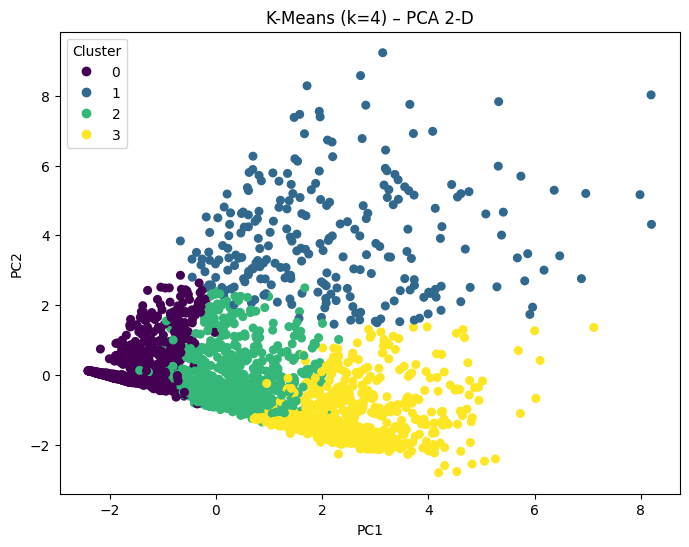

In [12]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(data_2d[:,0], data_2d[:,1], c=labels_km, cmap='viridis', s=30)
plt.title('K-Means (k=4) – PCA 2-D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

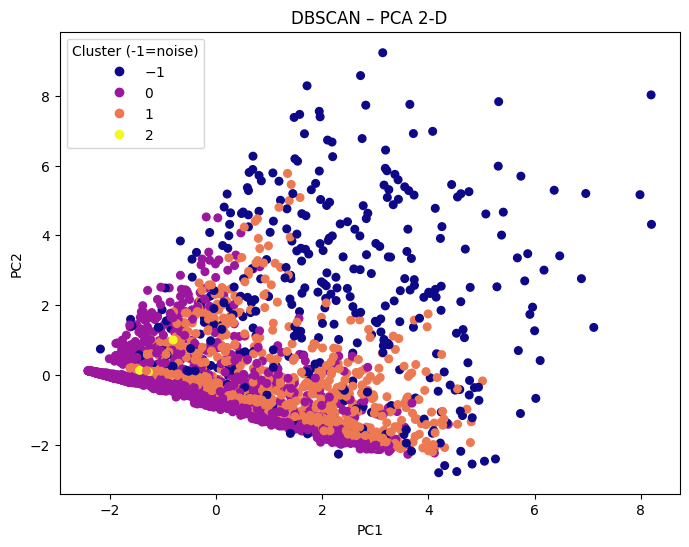

In [13]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(data_2d[:,0], data_2d[:,1], c=labels_db, cmap='plasma', s=30)
plt.title('DBSCAN – PCA 2-D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title="Cluster (-1=noise)")
plt.show()

In [14]:
# K-Means
sil_km = silhouette_score(data_std, labels_km)
print(f"K-Means silhouette : {sil_km:.3f}")

# DBSCAN
mask = labels_db != -1
if mask.sum() > 0:
    sil_db = silhouette_score(data_std[mask], labels_db[mask])
    print(f"DBSCAN silhouette (excluding noise) : {sil_db:.3f}")
else:
    print("DBSCAN produced only noise → silhouette not computed")

K-Means silhouette : 0.229
DBSCAN silhouette (excluding noise) : 0.276
